In [1]:
# Imports and reproducibility
!PYTHONHASHSEED=0
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

# Settings for prettier visualization in Google Colab
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [2]:
# VARIABILI GLOBALI
num_classes = 2

<IPython.core.display.Javascript object>

In [3]:
# CONNETTITI A DRIVE PER POTER LINKARE IL DATASET ED USARLO SENZA SCARICARLO
# IN LOCALE. LA CONNESSIONE CON DRIVE FUNZIONA UNICAMENTE SE ANCHE IL NOTEBOOK
# SI TROVA ALL'INTERNO DELLO STESSO DRIVE.

from google.colab import drive # importare pacchetto
drive.mount("/content/gdrive") # monta drive

<IPython.core.display.Javascript object>

Mounted at /content/gdrive


In [4]:
# IMPORTA IL FILE ZIP SULLA MACCHINA VIRTUALE DI GOOGLE COLAB
# CHE CI è STATA ASSEGNATA. FINO A QUESTO MOMENTO ABBIAMO SOLO MONTATO
# GOOGLE DRIVE. ORA DOBBIAMO ANDARE A COPIARE IL FILE (CHE SU GOOGLE DRIVE
# PER NOI ATTUALMENTE è SOLO UN LINK) DIRETTAMENTE NELLA MIA ROOT FOLDER
# DOVE STO LAVORANDO (PER AVERE IL VERO E PROPRIO FILE E NON SOLO IL LINK).

copyfile("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/Foundation_of_Deep_Learning/catvsdog.zip", "catvsdog.zip") # il secondo argomento dice dove andare a copiare il file. Lasciando solamente il nome del file la si copia direttamente nella root folder di Colab

<IPython.core.display.Javascript object>

'catvsdog.zip'

In [5]:
# ESTRAIAMO LO ZIP
zip = zipfile.ZipFile("catvsdog.zip") # inizializza lo zipper e poi invocare zip.extract()
zip.extractall()
zip.close()

<IPython.core.display.Javascript object>

La struttura della cartella che vediamo con la cartella *catvsdog* e poi le sottocartelle *cat* e *dog* è abbastanza standard con i vari framework di deep learning.

Andiamo a definire un data loader: è un concetto molto utile nel contesto del machine learning/deep learning. e' una classe/funzione, un costrutto che si occupa di caricare i dati dal disco e fornirli alla procedura di apprendimento ovvero al processo di training. l'idea è che non dobbiamo scriverci noi il codice per importarci l'immagine e darla in input alla funzione fit per
addestrare la nostra rete neurale.
Per il data loader in keras, facciamo riferimento al seguente link:
https://keras.io/api/preprocessing/image/

e usiamo:
image_dataset_from_directory

che è un data loader che si aspetta i dati nella struttura che abbiamo appena descritto, quindi cartelle con i file già divisi.



In [6]:
base_path = "catvsdog500/" # CREAZIONE DEL PATH. 500 PERCHé PRENDIAMO UN SET DI IMMAGINI PIù PICCOLO E NON TUTTE LE 25000.
train_dataset = keras.preprocessing.image_dataset_from_directory(base_path,
                                                 image_size = (224, 224),
                                                 batch_size = 32,
                                                 label_mode = "categorical",
                                                 subset = "training",
                                                 validation_split = 0.2,
                                                 shuffle = True,
                                                 seed = 1)

<IPython.core.display.Javascript object>

Found 1000 files belonging to 2 classes.
Using 800 files for training.


- *image_size*: resize dell'immagine. Perché? Perché il batch processing vede
n immagini alla volta. Queste devono essere impilate in un unico
tensore a 4 dimensioni e per poterlo fare devono avere
tutte la stessa dimensione. Un altro motivo per cui le immagini
vengono ridimensionate tutte alla stessa dimensione in un problema
di classificazione di immagini con delle reti neurali è che alcuni
livelli neurali funzionano indipendentemente dalla dimensione 
dell'input, altri sono costruiti, nel momento in cui li definiamo, si aspettano che l'input abbia una specifica cardinalità e se non riportiamo tutto alla stessa dimensione, avremo problemi successivi quando andiamo ad utilizzare questi layer.
224 x 224 pixel è la dimensione standard che molte reti neurali
possiamo già utilizzare perché pre implementate si aspettano.

- *batch_size*: non diamo in input al processo di training un'immagine alla volta, ma gliene diamo n, il batch size identifica esattamente questo. Valore arbitrario. Come rule of thumb: utilizza il batch size più grande possibile finché sta in memoria. Perché più grande possibile? Perché stiamo affrontando il problema di imparare la rete neurale usando lo Stochastic Gradient Descent (o una sua variante). Idealmente noi diamo tutti i dati in input alla rete neurale e la miglioriamo con l'obiettivo di migliorare le performance su tutti i dati in input.
Poiché non ci stanno tutti contemporaneamente li diamo poco per volta, ma non possiamo darne una solta alla volta: altrimenti l'algoritmo pensa il seguente: per questa singola immagine che vedo dovrò modificare i pesi in un certo modo; per la successiva singola immagine devo modificare i pesi in un altro modo. Il processo non è stabile! Quello che idealmente vorremmo trovare è un singolo criterio che possa modificare i pesi per tutte o il maggior numero di immagini possibili.

- *label_mode* = categorical. Le nostre classi sono identificate da delle etichette (cat e dog) che verranno automaticamente inferite dai nomi delle cartelle. 

- *subset* = One of "training" or "validation". Only used if validation_split is set.

- *validation_split* = Optional float between 0 and 1, fraction of data to reserve for validation.

- *shuffle* = True. Imposta che le immagini non vengano prese in ordine del nome del file ma vengano riordinate casualmente
L'intero comando prenderà le cartelle con i file e deciderà autonomamente di prendere l'80% da usare per il training e il 20% da usare per il validation.

Del totale dei 1000 file, 800 vengono usati per il training (addestramento) e, successivamente quando specifichiamo il validation, vedimo che 200 file vengono usati per il validation, cioè il restante 20%. 

In [7]:
val_dataset = keras.preprocessing.image_dataset_from_directory(base_path,
                                                 image_size = (224, 224),
                                                 batch_size = 32,
                                                 label_mode = "categorical",
                                                 subset = "validation",
                                                 validation_split = 0.2,
                                                 shuffle = True,
                                                 seed = 1)

<IPython.core.display.Javascript object>

Found 1000 files belonging to 2 classes.
Using 200 files for validation.


## Architettura della rete

Che caratteristiche dovrà avere la nostra rete neurale?
- input layer
- 2D convolutional layer con le seguenti caratteristiche: 
  - 3x3 filter (ogni filto di un layer di convoluzione 2D ha una certa dimensione spaziale che è questo 3x3 che occupa in profondità qualunque sia la dimensione dell'input) e di questi ne vogliamo 32.
- relu activation function (con un layer a parte o inserita nel layer precedente)
- max pooling (con un filtro 3x3)
- 2D convolutional layer che mappi a 64 canali (filtro 3x3 che mappa a 64 canali)
- relu activation function
- maxpooling globale: non andiamo più a dire quale è la dimensione del filtro, ma vogliamo che sia automaticamente determinata prendendo spazialmente tutti i pixel di un canale e li riduca ad un numero. Poi passi al canale successivo, prenda tutti i pixel di quel canale e li riduca ad un numero usando l'operazione del max pooling
- fully connected (Dense in keras) che mappi a 2 (dando la probabilità che sia cane/gatto con activation SoftMax
- rmspropr e learning rate = 0.001.

In [8]:
# ARCHITETTURA DI RETE CONVOLUZIONALE PER CLASSIFICAZIONE DI IMMAGINI CAT/DOG

inputs = keras.Input((224, 224, 3)) # 224 rows, 224 columns, 3 RGB channels

x = inputs
# 32 filtri 3x3. Padding: mi dice quanti pixel aggiungere di cornice alla mia 
# immagine prima di fare la convoluzione. Se non fornito, l'output della 
# convoluzione produrrà un immagine un pelo più piccola di quella di partenza 
# spazialmente: nel far scorrere la finestra di convoluzione non riesce a coprire
# l'intorno del pixel di riferimento nell'immagine. Dando "same" il padding
# viene calcolato automaticamente. 
x = keras.layers.Conv2D(32, 3, padding='same')(x)
# Attivazione ReLU: la funzione di attivazione introduce una non linearità.
# Fa si che il calcolo che permette di trasformare i numeri che stanno nell'input
# nei numeri che stanno nell'output non sia semplicemente una combinazione
# lineare dell'input, ma in generale crea un livello di complessità maggiore
# che è quello di costruire delle astrazioni, ovvero permette alla rete neurale
# di dire: ok, adesso ho individuato delle linee di base, ora ci costruisco
# sopra dei ragionamenti più complessi.
# x = keras.layers.Activation('relu')(x)
x = keras.layers.Activation('relu')(x)
# MaxPooling con finestre/windows 3x3 e stride di 3: ciò significa che ogni
# 3x3 valori dell'input li sostituiamo con il suo Max e poi quando spostiamo
# la finestra che esegue questa operazione, la spostiamo di 3 pixels a destra.
# Così facendo non contiamo più volte lo stesso input e in questo caso l'output
# di questo layer sarà per definizione più piccolo spazialmente dell'input.
# E' un tipo di layer che ci serve concettualmente per essere meno dipendenti
# da eventuali piccole variazioni nell'input (se ci sono tralazione dei dati
# di un pixel a destra) il Max Pooling è abbastanza robusto da queste variazioni
# trascendendo di qualche misura da variazioni dei dati. 
# Tra l'altro se lo usiamo con questo stride diminuisce la dimensione dell'input
# e la complessità dei valori che portiamo avanti nella rete neurale. Stiamo
# infatti passando da 224x224x3 valori a 3 numeri. 
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x) 

x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)

# Equivalente del Max Pooling ma in automatico calcola, invece che basarsi su
# una finestra 3x3 utilizza una finestra grande quanto l'intera attivazione
# del layer precedente.
x = keras.layers.GlobalMaxPooling2D()(x)

# Questa softmax prende i due numeri (le due classi specificate) e dà in input
# una funzione che ha lo scopo di produrre una pseudo distrubuzione di 
# probabilità. Si assicura che la somma dei valori (dei due valori nel nostro
# caso), faccia 1, e introduce delle non linearità.
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Con questo comando impacchettiamo tutti i nostri passaggi e diciamo 
# che la mia rete neurale è un modello che parte dalla variabile "inputs" e
# termina con la variabile chiamata "outputs". 
net = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

Commento al codice di creazione dell'architettura.

- layer di input = non è indispensabile per definire una rete neurale, ma può essere utile perché se noi informiamo tutto il resto dell'architettura che i nostri dati in input hanno 3 canali, nel momento in cui dichiariamo la convoluzione 2D non abbiamo bisogno di dire quanto è grande la dimensione in input perché viene definita direttamente.  

In [9]:
# La compilazione ci serve per definire quali sono le procedure utilizzate 
# durante l'addestramento. La loss in questa esercitazione non è più la differenza
# tra valore di regressione target e quello stimato ma "categorical_crossentropy".
# Per ogni immagine (dato di input) dice: guardiamo la mi ground truth. Quale era
# la classe della mia immagine? Era gatto (prima classe). Andiamo a vedere se
# nel primo dei due valori restituiti dalla rete neurale per quella immagine
# c'è un valore molto alto (idealmente deve essere 1). Più è distante la stima
# della classe attesa da 1 e maggiore è la loss (peggior risultato all'aumentare
# del valore di Loss). 
# Ottimizzatore: basato su RMSProp;
# Salviamoci l'accuracy: ci dice sul totale delle immagini quante sono state
# correttamente classificate.
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [10]:
# SETTINGS FOR PRETTIER VISUALIZATION IN GOOGLE COLAB
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

<IPython.core.display.Javascript object>

In [11]:
# SE LA VOLTA SCORSA POTEVAMO PERMETTERCI DI AVERE IN MEMORIA TUTTO IL DATASET
# QUA NON POSSIAMO FARE ALTRETTANTO PERCHé ABBIAMO IMMAGINI E NON C'è
# MODO DI CARICARE TUTTO IL DATASET IN MEMORIA ALLA PROCEDURA DI FIT. 
# MOTIVO PER IL QUALE STIAMO UTILIZZANDO IL DATA LOADER DEFINITO ALL'INIZIO. 
# AVENDOLO SPECIFICATO ALL'INIZIO IL TRAIN_DATASET PRENDERà IN INGRESSO 32
# IMMAGINI ALLA VOLTA, DEFINITO COME BATCH SIZE FINO A COPRIRE L'INTERO DATASET.
# COSI FACENDO HA COMPLETATO UNA EPOCA E TIRA IN BALLO IL VALIDATION
# DATA LOADER CHE CONGELA MOMENTANEAMENTE L'ADDESTRAMENTO DELLA RETE NEURALE,
# FORNISCE ALLA RETE TUTTE LE IMMAGINI DEL VALIDATION SET (ANCHE IN QUESTO
# CASO 32 ALLA VOLTA) E CALCOLA IL RISULTATO. E SALVIAMO IL RISULTATO NELLA
# VARIABILE HISTORY.
history = net.fit(train_dataset, epochs=40, validation_data = val_dataset)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/40
25/25 [==============================] - 12s 77ms/step - loss: 18.9361 - accuracy: 0.4875 - val_loss: 5.7750 - val_accuracy: 0.5000
Epoch 2/40
25/25 [==============================] - 2s 68ms/step - loss: 4.9905 - accuracy: 0.5425 - val_loss: 10.0173 - val_accuracy: 0.5150
Epoch 3/40
25/25 [==============================] - 2s 66ms/step - loss: 3.2858 - accuracy: 0.5600 - val_loss: 2.4992 - val_accuracy: 0.5250
Epoch 4/40
25/25 [==============================] - 2s 68ms/step - loss: 2.1718 - accuracy: 0.5425 - val_loss: 2.0875 - val_accuracy: 0.5300
Epoch 5/40
25/25 [==============================] - 2s 79ms/step - loss: 1.3213 - accuracy: 0.5738 - val_loss: 1.2336 - val_accuracy: 0.5600
Epoch 6/40
25/25 [==============================] - 3s 95ms/step - loss: 1.0392 - accuracy: 0.6200 - val_loss: 1.1715 - val_accuracy: 0.5100
Epoch 7/40
25/25 [==============================] - 3s 79ms/step - loss: 0.8472 - accuracy: 0.6463 - val_loss: 1.0884 - val_accuracy: 0.5500
Epoch 8/40

Visualizziamo le curve di accuracy.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

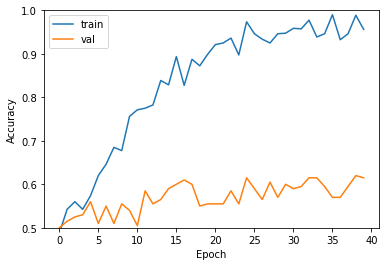

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

Su dati mai visti non un granché.
Come miglioriamo il risultato? Introducendo la batch normalization, un layer dopo ciascuna convoluzione 2D.
Quindi, riprendiamo la rete definita precedentemente e inseriamo la batch normalization.

Quindi:
- Add a batchnorm layer after every conv2D layer
- compile
- fit

In [13]:
# NUOVA ARCHITETTURA DI RETE CONVOLUZIONALE CON BATCH NORMALIZATION

inputs = keras.Input((224, 224, 3)) # 224 rows, 224 columns, 3 RGB channels

x = inputs
x = keras.layers.Conv2D(32, 3, padding='same')(x)
# AGGIUNGI BATCH NORMALIZATION LAYER
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x) 

x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
# AGGIUNGI BATCH NORMALIZATION LAYER
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# RICOOMPILIAMO
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# RIFITTIAMO
history = net.fit(train_dataset, epochs=40, validation_data = val_dataset)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/40
25/25 [==============================] - 3s 93ms/step - loss: 1.4432 - accuracy: 0.5038 - val_loss: 1.0968 - val_accuracy: 0.5500
Epoch 2/40
25/25 [==============================] - 3s 93ms/step - loss: 0.7891 - accuracy: 0.5850 - val_loss: 1.4388 - val_accuracy: 0.5250
Epoch 3/40
25/25 [==============================] - 3s 90ms/step - loss: 0.7363 - accuracy: 0.6388 - val_loss: 1.3954 - val_accuracy: 0.5150
Epoch 4/40
25/25 [==============================] - 2s 77ms/step - loss: 0.6650 - accuracy: 0.6513 - val_loss: 1.1504 - val_accuracy: 0.5150
Epoch 5/40
25/25 [==============================] - 2s 76ms/step - loss: 0.6272 - accuracy: 0.6712 - val_loss: 0.7863 - val_accuracy: 0.6200
Epoch 6/40
25/25 [==============================] - 2s 75ms/step - loss: 0.5636 - accuracy: 0.7200 - val_loss: 0.6950 - val_accuracy: 0.6200
Epoch 7/40
25/25 [==============================] - 3s 93ms/step - loss: 0.5685 - accuracy: 0.7237 - val_loss: 0.6736 - val_accuracy: 0.6550
Epoch 8/40
25

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

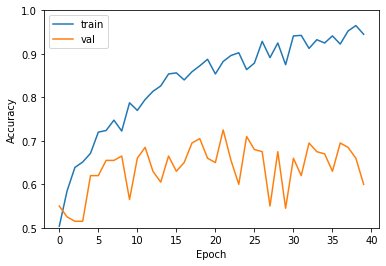

In [16]:
# VISUALIZZIAMO NUOVAMENTE L'OUTPUT
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

Idea della batch normalization: standardizza i dati per il livello successivo. I dati di partenza nella variabile inputs si trovano tra 0 e 255 o tra 0 e 1 a seconda di come è trattato l'input. Nel momento in cui applichiamo una convoluzione 2D coon dei filtri inizializzati con valori randomici è difficile prevedere che valore (range) avrà l'output e più si va a fondo di una rete neurale è più è imprevedibile sapere che range di valori hanno le attivazioni (le attivazioni sono gli output dei layers). Per alcuni livelli neurali questo può essere un problema: la batch normalization si occupa di riportare i dati sempre in un stesso range (non è un range specifico). Quello che fa è portare la media del training set a 0 e la std del training set a 1. Questa normalizzazione permette di migliorare l'apprendimento dei layer successivi. E' una forma di regolarizzazione. 

Il miglioramento ci fa arrivare al 65% anche se non ci fa impazzire.
Avendo fatto un passo per combattere l'overfitting (accuracy sul training elevata, mentre l'accuracy sul validation bassa), proviamo ad aumentare la complessità della rete, facendola più profonda (128 neuroni - quello che vogliamo fare approfondendo la rete è di diminuire la dimensione spaziale, cosa fatta col Max Pooling e allo stesso tempo aumentare la profondità dei canali, da 32 a 64 a 128).

Riprendiamo il codice della rete precedente e aggiungiamo un altro blocco di convolution, batch, activation e Max Pooling.

In [17]:
# NUOVA ARCHITETTURA CON UN "BLOCCO" AGGIUNTIVO

inputs = keras.Input((224, 224, 3)) # 224 rows, 224 columns, 3 RGB channels

x = inputs
x = keras.layers.Conv2D(32, 3, padding='same')(x)
# AGGIUNGI BATCH NORMALIZATION LAYER
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x) 

x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
# AGGIUNGI BATCH NORMALIZATION LAYER
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
# QUI AGGIUNGIAMO UN MAX POOLING ANCHE IN QUESTO BLOCCO
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x) 

x = keras.layers.Conv2D(128, 3, padding = 'same')(x)
# AGGIUNGI BATCH NORMALIZATION LAYER
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# RICOOMPILIAMO
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# RIFITTIAMO
history = net.fit(train_dataset, epochs=40, validation_data = val_dataset)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/40
25/25 [==============================] - 4s 82ms/step - loss: 1.2362 - accuracy: 0.5375 - val_loss: 0.9640 - val_accuracy: 0.4900
Epoch 2/40
25/25 [==============================] - 2s 78ms/step - loss: 0.6351 - accuracy: 0.6712 - val_loss: 0.9680 - val_accuracy: 0.5100
Epoch 3/40
25/25 [==============================] - 2s 77ms/step - loss: 0.5951 - accuracy: 0.7100 - val_loss: 0.9170 - val_accuracy: 0.5200
Epoch 4/40
25/25 [==============================] - 2s 78ms/step - loss: 0.4855 - accuracy: 0.7575 - val_loss: 0.9838 - val_accuracy: 0.5200
Epoch 5/40
25/25 [==============================] - 2s 78ms/step - loss: 0.4015 - accuracy: 0.8238 - val_loss: 0.7429 - val_accuracy: 0.6300
Epoch 6/40
25/25 [==============================] - 2s 78ms/step - loss: 0.3728 - accuracy: 0.8500 - val_loss: 0.7029 - val_accuracy: 0.6300
Epoch 7/40
25/25 [==============================] - 2s 78ms/step - loss: 0.3787 - accuracy: 0.8338 - val_loss: 0.6584 - val_accuracy: 0.6450
Epoch 8/40
25

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

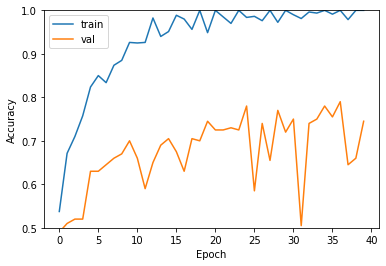

In [20]:
# VISUALIZZIAMO NUOVAMENTE L'OUTPUT
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

## Nel notebook della lezione sono presenti altri passaggi che non sono stati visti a lezione ma che potrebbero essere importanti da guardare anche in vista del progetto!

Per ora visualizziamo l'architettura che abbiamo definito: sarebbe utile avere una sorta di report dell'architettura definita anche per fare una sorta di debug dell'architettura definita.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

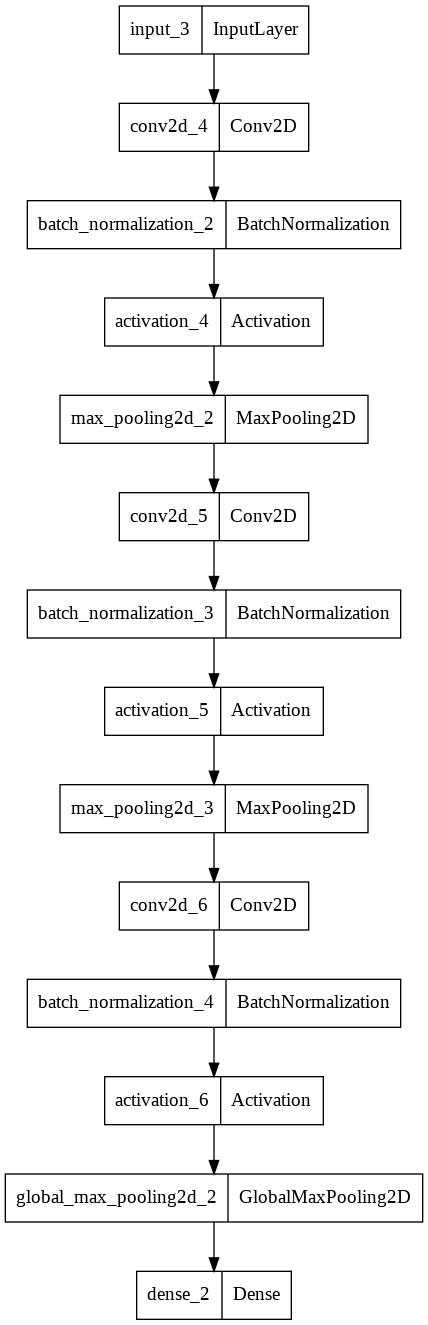

In [22]:
# IN QUESTO CASO NON è MOLTO SIGNIFICATIVO PERCHé L'ARCHITETTURA
# E' SEQUENZIALE: ABBIAMO UN LAYER SEGUITO DA UN ALTRO LAYER ETC.
keras.utils.plot_model(net)

In [23]:
# TABELLA UTILE PER LA DIMENSIONE DELLE ATTIVAZIONI E SUL 
# NUMERO DI PARAMETRI. PER CIASCUN LAYER CI DICE QUANTO ERA GRANDE
# 
net.summary()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        1849

Fin'ora abbiamo sempre visto l'accuracy, ovvero numero di immagini classificate correttamente. Ora visualizziamo la loss function. Se l'accuracy la vogliamo massimizzare (è una metrica, la vediamo post ma non influenza l'addestramento), la loss è invece quello che vogliamo utilizzare per guidare l'addestramento ed è qualcosa che vogliamo minimizzare: più è basso il valore è meglio è. Per il problema di classificazione la loss dice quanto la celletta con i valori di probabilità della classe che era attesa è effettivamente vicina ad 1: se molto vicino, la loss è bassa e stiamo andando bene, se molto lontano da 1 la loss è alta e stiamo andando male, calcolata per tutto il dataset.

ARRIVATO A 1:21:15 LEZIONE E04.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

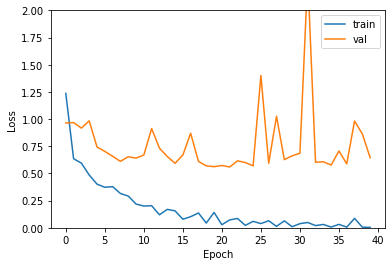

In [24]:
# VISUALIZZIAMO NUOVAMENTE L'OUTPUT
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'])